In [3]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [4]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [5]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [6]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
# General
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import random
pd.set_option('display.max_columns', None)
# Visialisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
# Machine Learning
# Utils
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn import preprocessing
#Feature Selection
from sklearn.feature_selection import chi2, f_classif, f_regression, mutual_info_classif
from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectPercentile
from sklearn.feature_selection import VarianceThreshold
# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
# Unsupervised Models
from sklearn.cluster import KMeans
#Metrics
from sklearn.metrics import roc_auc_score

# Fixing Seed
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything()

In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sub_df = pd.read_csv("sample_submission.csv")

In [8]:
train_df.sample(10)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
241356,FO27LBAN,Female,82,RG251,Other,X2,51,Yes,441769,No,0
150884,AJ9PANHI,Male,52,RG280,Self_Employed,X3,62,No,661554,No,0
43550,HY8ZRRB9,Male,31,RG284,Salaried,X1,25,Yes,2151922,No,0
62555,ORLPS7JG,Female,33,RG268,Self_Employed,X1,27,No,2525072,No,0
147096,D2JZQYRX,Male,30,RG251,Salaried,X1,19,No,2156763,No,0
158752,RCSPEYRC,Female,59,RG268,Self_Employed,X3,110,Yes,997974,Yes,0
126437,FJYNYM4R,Male,37,RG264,Salaried,X1,27,No,721158,No,0
153937,WUHVTVQP,Male,28,RG262,Other,X1,19,Yes,6293065,No,0
120164,M7DKKJDF,Female,47,RG284,Self_Employed,X3,62,No,1215651,Yes,0
87494,NVDVUQFA,Male,55,RG280,Self_Employed,X2,37,No,718069,Yes,0


In [9]:
train_df.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

In [10]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,245725.0,4.385631e+01,14.828672,23.0,30.0,43.0,54.0,85.0
Vintage,245725.0,4.695914e+01,32.353136,7.0,20.0,32.0,73.0,135.0
Avg_Account_Balance,245725.0,1.128403e+06,852936.356069,20790.0,604310.0,894601.0,1366666.0,10352009.0
Is_Lead,245725.0,2.372083e-01,0.425372,0.0,0.0,0.0,0.0,1.0


In [11]:
np.sum(train_df.isnull())

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

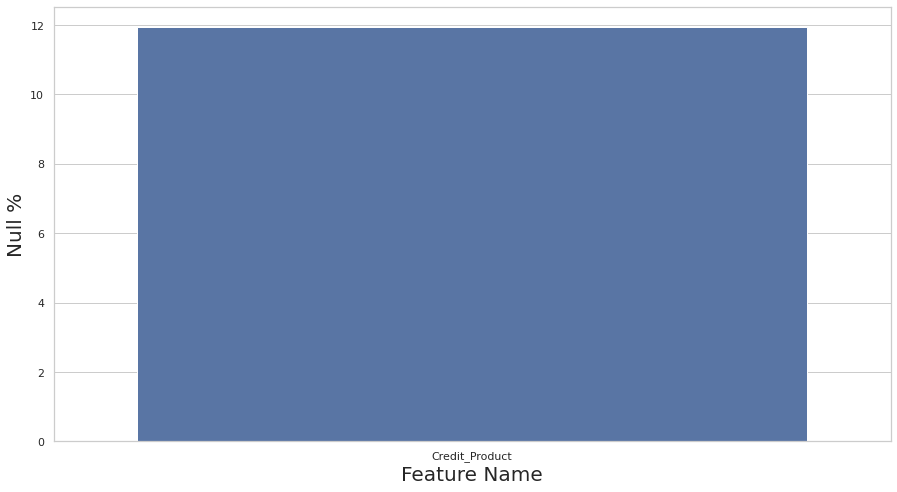

In [12]:
#Null Values
nulls_train = np.sum(train_df.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)
nullcols_train = nullcols_train.apply(lambda x: 100*x/train_df.shape[0])

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null %", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()

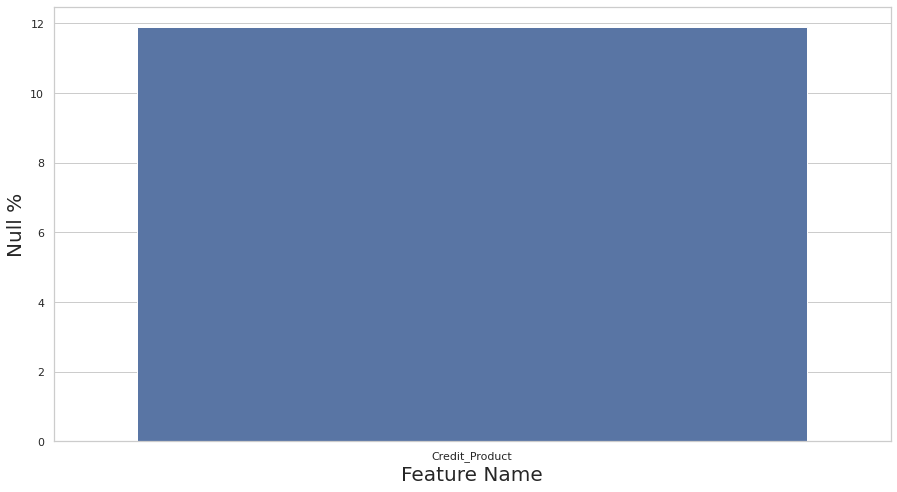

In [13]:
nulls_train = np.sum(test_df.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)
nullcols_train = nullcols_train.apply(lambda x: 100*x/test_df.shape[0])

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null %", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()

In [14]:
train_df['Credit_Product'].fillna('Unk', inplace=True)
test_df['Credit_Product'].fillna('Unk', inplace=True)

In [15]:
train_df['Credit_Product_Known'] = train_df['Credit_Product'].apply(lambda x: 0 if x == 'Unk' else 1)
test_df['Credit_Product_Known'] = test_df['Credit_Product'].apply(lambda x: 0 if x == 'Unk' else 1)

In [16]:
np.sum(train_df.isnull())

ID                      0
Gender                  0
Age                     0
Region_Code             0
Occupation              0
Channel_Code            0
Vintage                 0
Credit_Product          0
Avg_Account_Balance     0
Is_Active               0
Is_Lead                 0
Credit_Product_Known    0
dtype: int64

In [17]:
np.sum(test_df.isnull())

ID                      0
Gender                  0
Age                     0
Region_Code             0
Occupation              0
Channel_Code            0
Vintage                 0
Credit_Product          0
Avg_Account_Balance     0
Is_Active               0
Credit_Product_Known    0
dtype: int64

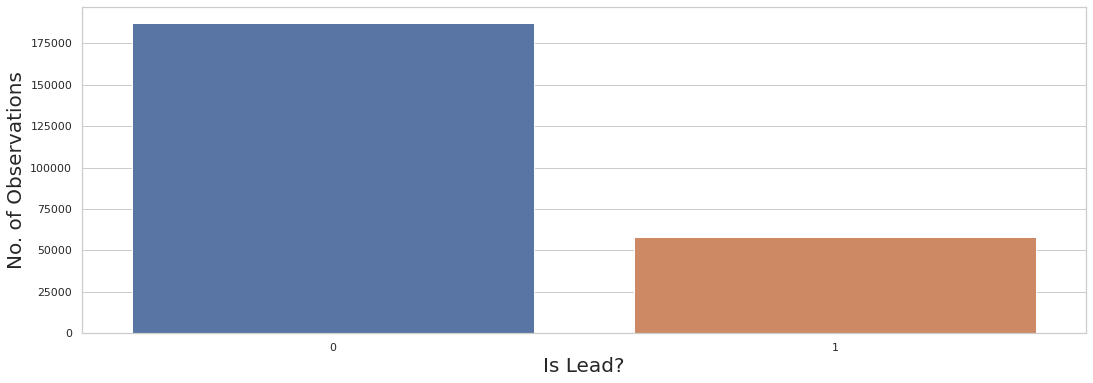

In [18]:
#Class Imbalance
ax = plt.subplots(figsize=(18, 6))
sns.set_style("whitegrid")
sns.countplot(x='Is_Lead', data=train_df);
plt.ylabel("No. of Observations", size=20);
plt.xlabel("Is Lead?", size=20);

In [19]:
imbalance_ratio = train_df[train_df['Is_Lead'] == 0].shape[0]/train_df[train_df['Is_Lead'] == 1].shape[0]
print(f'Imbalance ratio: {imbalance_ratio}')

Imbalance ratio: 3.215704776283283


In [20]:
#Feature Value Counts
train_df.nunique()

ID                      245725
Gender                       2
Age                         63
Region_Code                 35
Occupation                   4
Channel_Code                 4
Vintage                     66
Credit_Product               3
Avg_Account_Balance     135292
Is_Active                    2
Is_Lead                      2
Credit_Product_Known         2
dtype: int64

In [21]:
train_df.shape

(245725, 12)

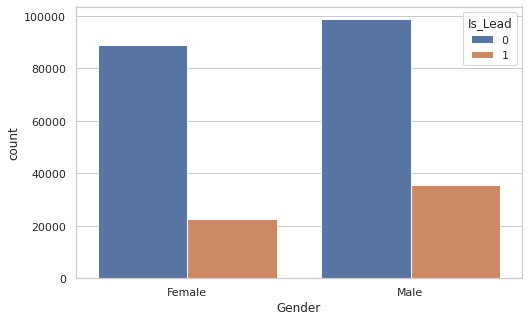

In [22]:
#Gender
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.countplot(x='Gender', hue='Is_Lead', data=train_df);

In [23]:
# Response Rate from Gender
v = train_df.groupby('Gender').Is_Lead.value_counts().unstack()
v['Ratio'] = v[1]/(v[0] + v[1])
v.reset_index(inplace=True)

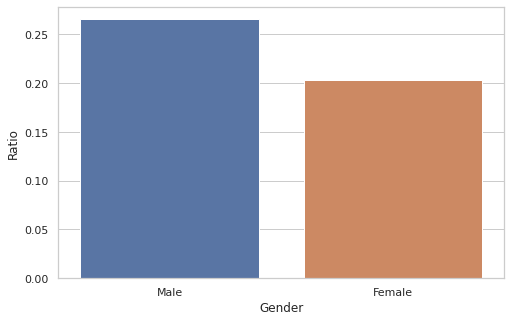

In [24]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.barplot(x='Gender', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));

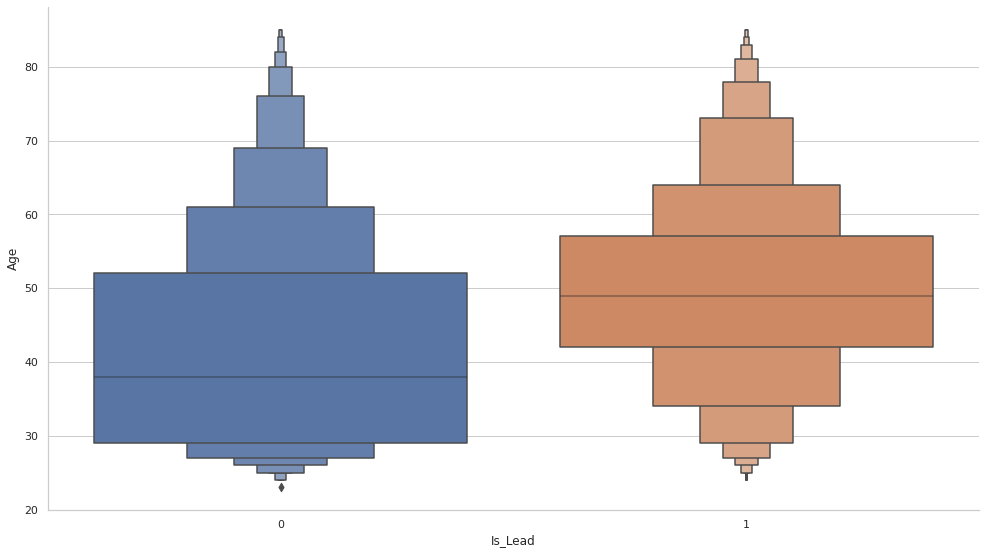

In [25]:
#Age
g = sns.catplot(x='Is_Lead', y='Age', kind='boxen', data=train_df);
g.fig.set_size_inches(15,8)

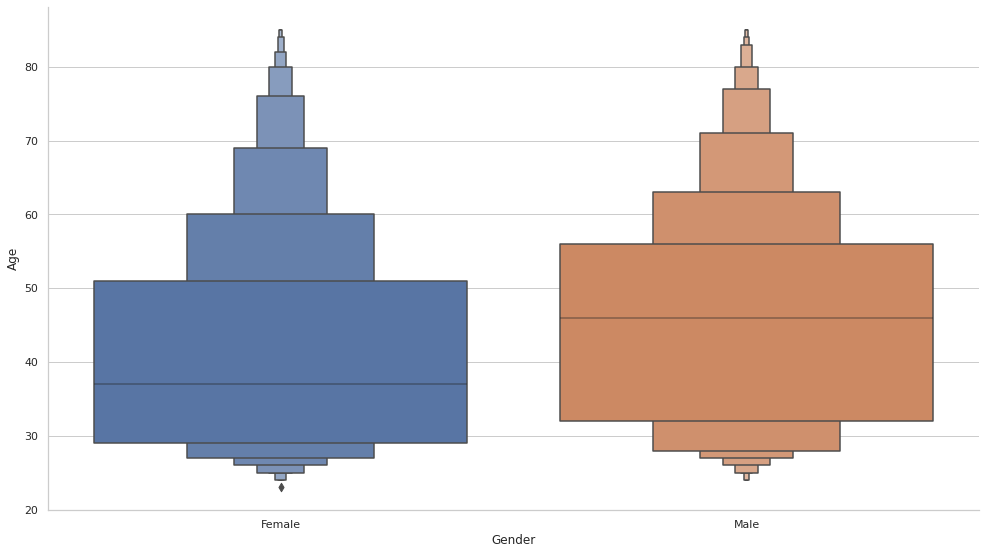

In [26]:
g = sns.catplot(x='Gender', y='Age', kind='boxen', data=train_df);
g.fig.set_size_inches(15,8)

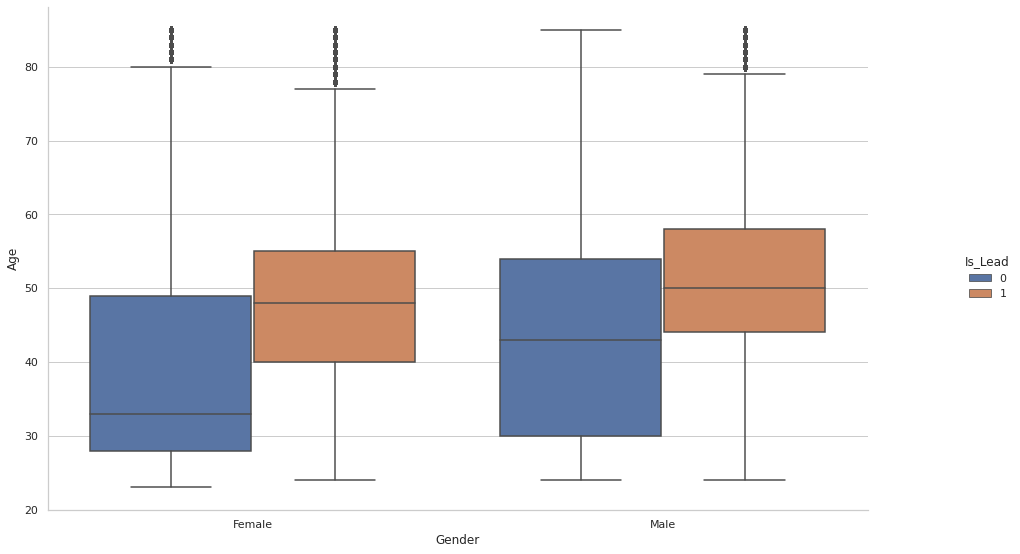

In [27]:
g = sns.catplot(x='Gender', y='Age', hue='Is_Lead', kind='box', data=train_df);
g.fig.set_size_inches(15,8)

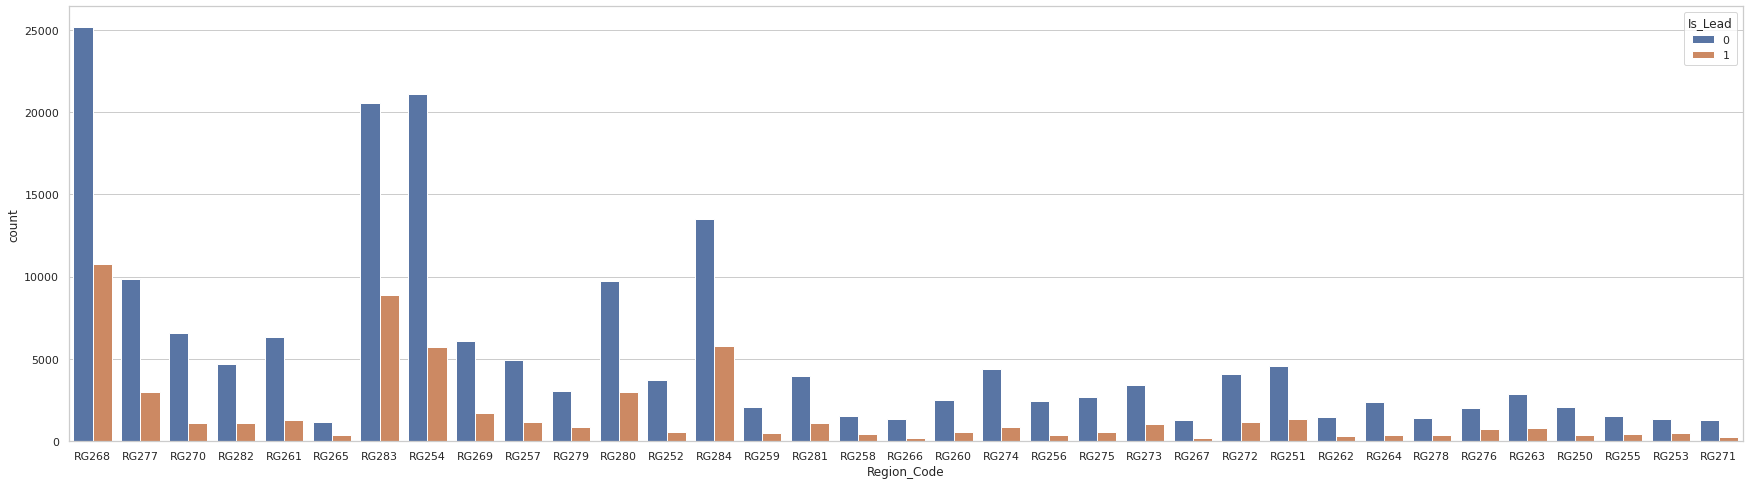

In [28]:
# Region Code
ax = plt.subplots(figsize=(30, 8))
sns.set_style("whitegrid")
sns.countplot(x='Region_Code', hue='Is_Lead', data=train_df);

In [29]:
# Response Rate from Cities
v = train_df.groupby('Region_Code').Is_Lead.value_counts().unstack()
v['Ratio'] = v[1]/(v[0] + v[1])
v.reset_index(inplace=True)

In [30]:
v['Ratio'].mean()

0.20724818735170963

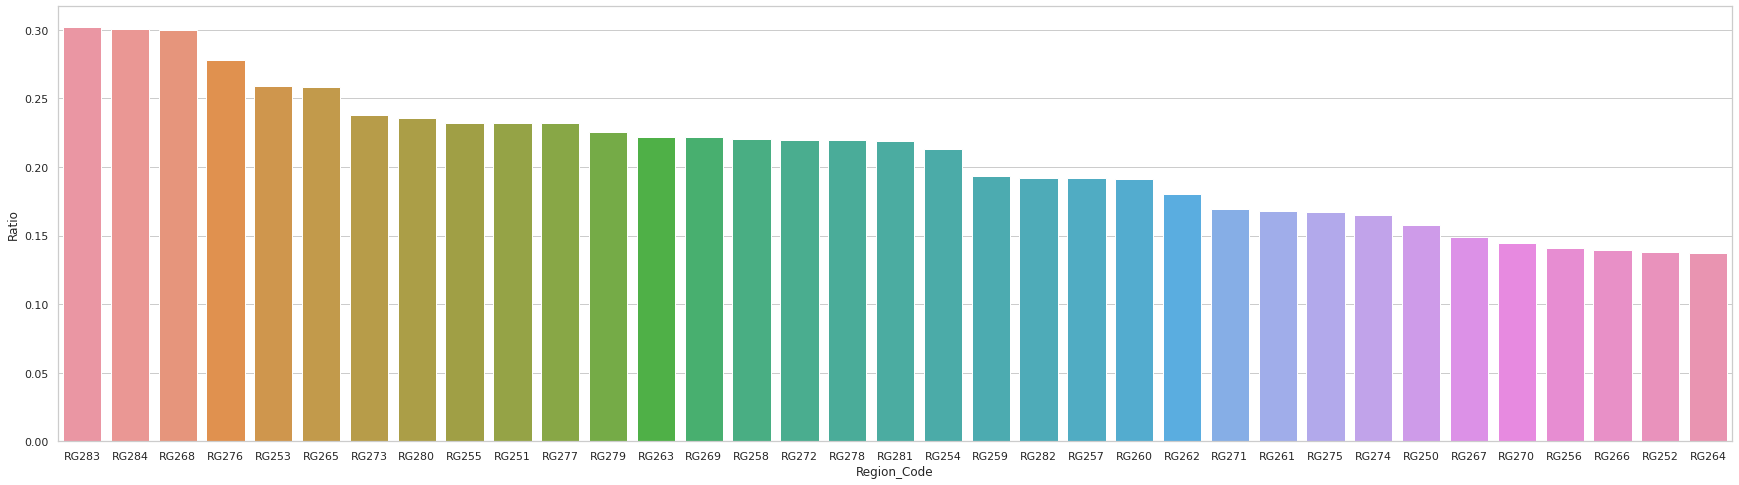

In [31]:
ax = plt.subplots(figsize=(30, 8))
sns.set_style("whitegrid")
sns.barplot(x='Region_Code', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));

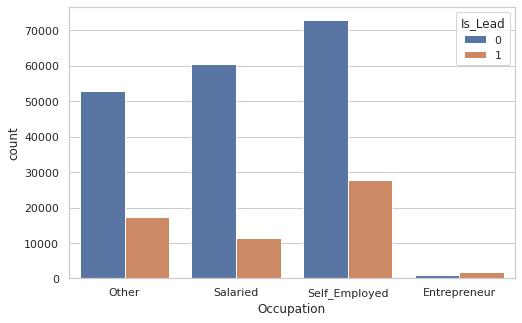

In [32]:
#Occupation
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.countplot(x='Occupation', hue='Is_Lead', data=train_df);

In [33]:
# Response Rate from Occupation
v = train_df.groupby('Occupation').Is_Lead.value_counts().unstack()
v['Ratio'] = v[1]/(v[0] + v[1])
v.reset_index(inplace=True)

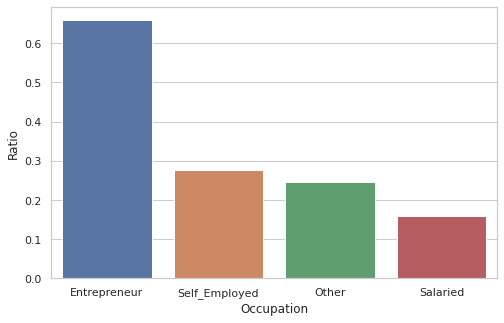

In [34]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.barplot(x='Occupation', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));

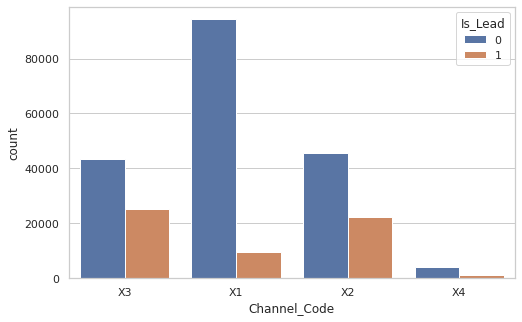

In [35]:
# Channel Code
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.countplot(x='Channel_Code', hue='Is_Lead', data=train_df);

In [36]:
# Response Rate from Channel_Code
v = train_df.groupby('Channel_Code').Is_Lead.value_counts().unstack()
v['Ratio'] = v[1]/(v[0] + v[1])
v.reset_index(inplace=True)

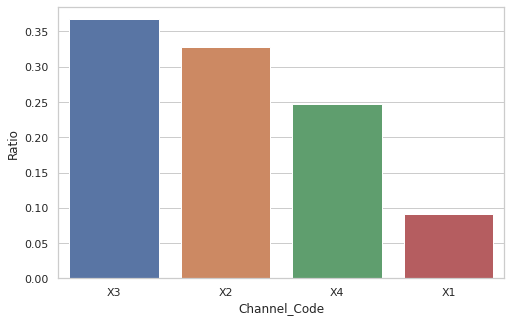

In [37]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.barplot(x='Channel_Code', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));

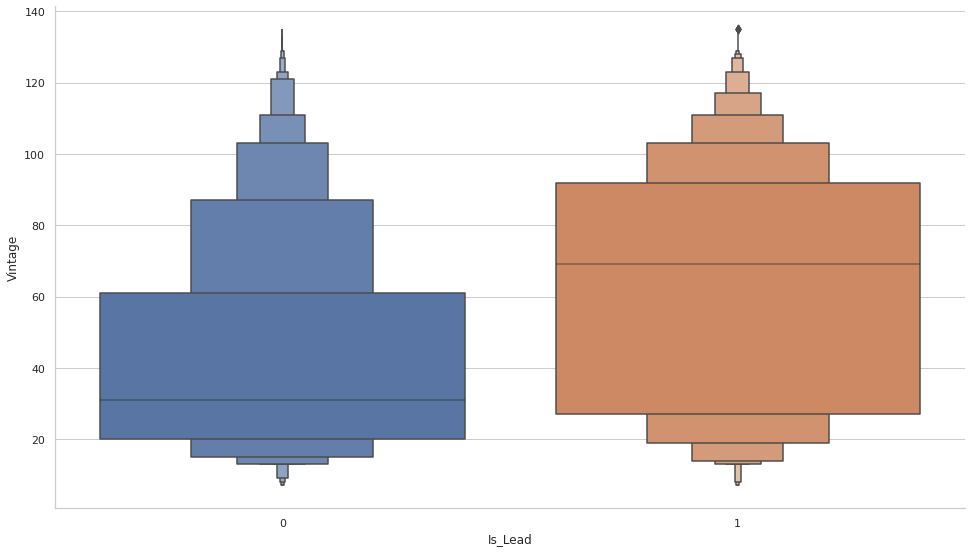

In [38]:
# Vintage
g = sns.catplot(x='Is_Lead', y='Vintage', kind='boxen', data=train_df);
g.fig.set_size_inches(15,8)

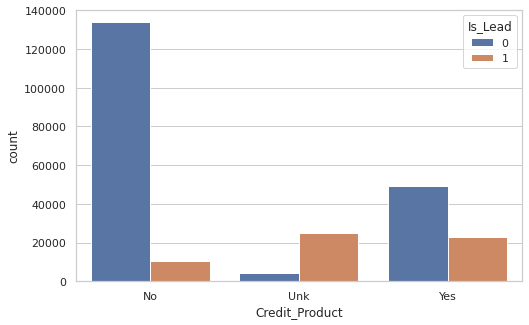

In [39]:
#Credit Product
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.countplot(x='Credit_Product', hue='Is_Lead', data=train_df);

In [40]:
# Response Rate from Credit_Product
v = train_df.groupby('Credit_Product').Is_Lead.value_counts().unstack()
v['Ratio'] = v[1]/(v[0] + v[1])
v.reset_index(inplace=True)

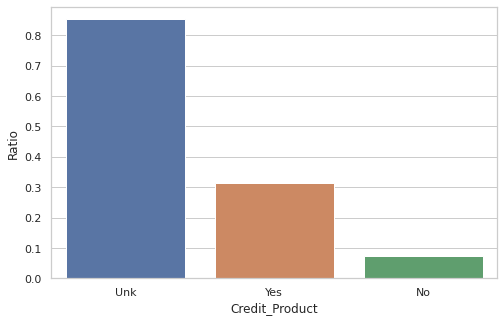

In [41]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.barplot(x='Credit_Product', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));

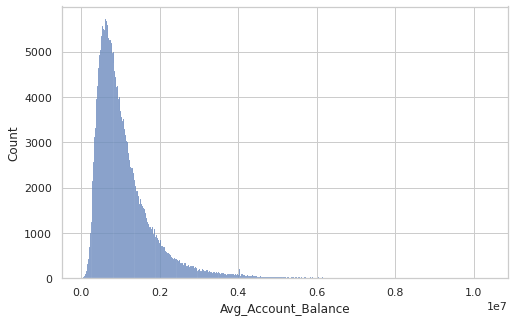

In [42]:
#Avg Account Balance
ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=train_df, x='Avg_Account_Balance');

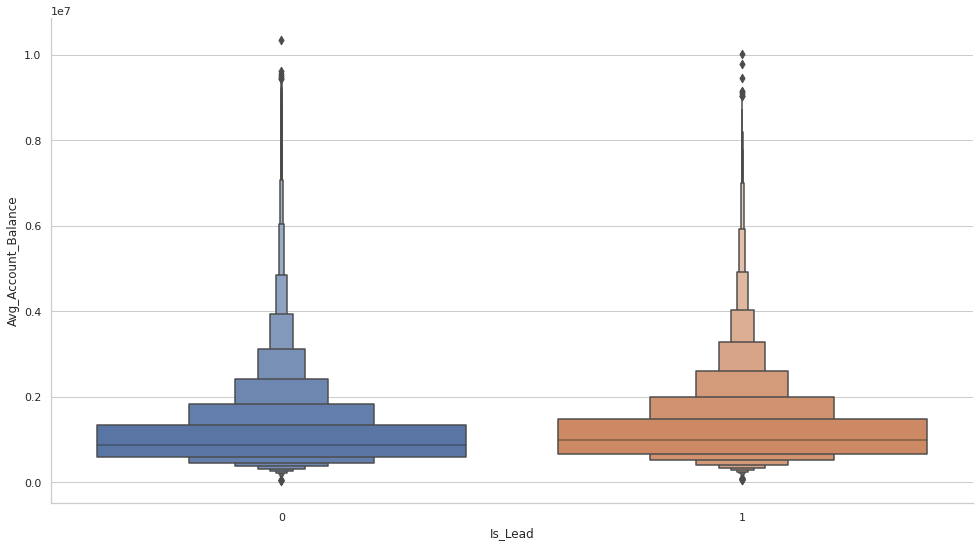

In [43]:
g = sns.catplot(x='Is_Lead', y='Avg_Account_Balance', kind='boxen', data=train_df);
g.fig.set_size_inches(15,8)

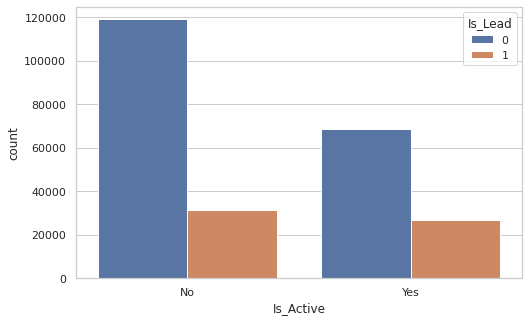

In [44]:
#Is Active
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.countplot(x='Is_Active', hue='Is_Lead', data=train_df);

In [45]:
# Response Rate from Is_Active
v = train_df.groupby('Is_Active').Is_Lead.value_counts().unstack()
v['Ratio'] = v[1]/(v[0] + v[1])
v.reset_index(inplace=True)

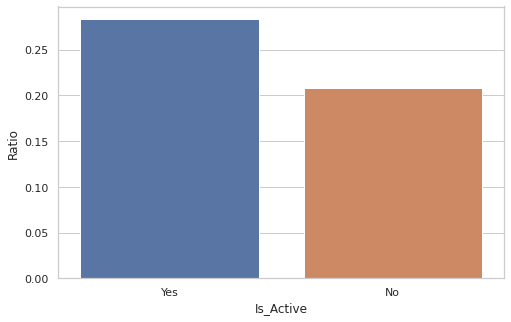

In [46]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.barplot(x='Is_Active', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));

In [47]:
target = ['Is_Lead']
not_features = ['ID', 'Is_Lead']
cols = list(train_df.columns)
features = [feat for feat in cols if feat not in not_features]
print(features)

['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Credit_Product_Known']


In [48]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_features = []
numerical_features = []

for i in features:
    if train_df[i].dtype in numerics:
        numerical_features.append(i)
    else:
        categorical_features.append(i)
        
print(f'Numeric features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

Numeric features: ['Age', 'Vintage', 'Avg_Account_Balance', 'Credit_Product_Known']
Categorical features: ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']


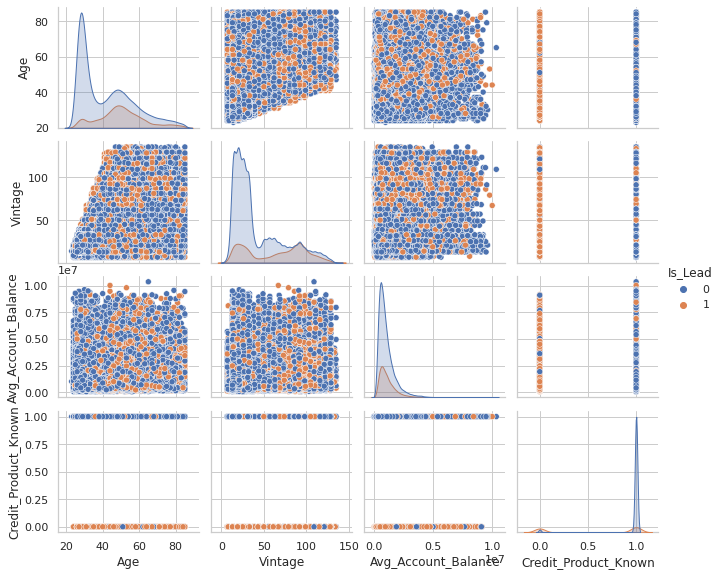

In [49]:
#Numerical Feature Interactions
g = sns.pairplot(train_df[numerical_features + ['Is_Lead']], hue='Is_Lead')
g.fig.set_size_inches(10,8)

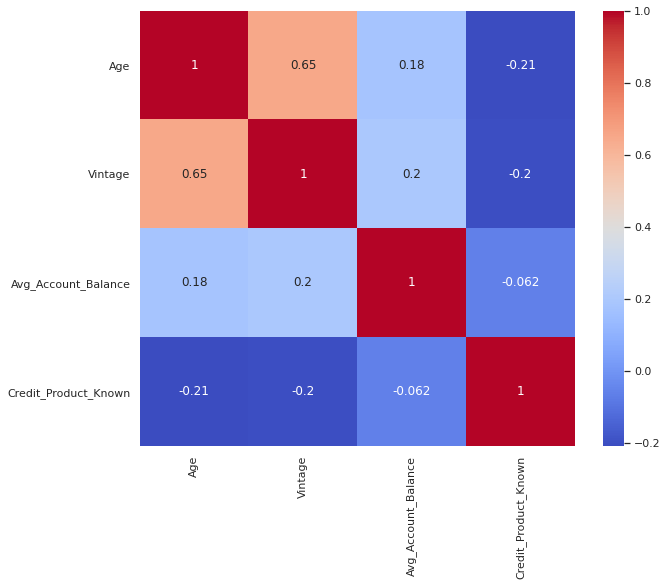

In [50]:
train_df_cor_spear = train_df[numerical_features].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(train_df_cor_spear, square=True, cmap='coolwarm', annot=True);

In [51]:
#KFolds Split
NUM_SPLITS = 5

train_df["kfold"] = -1
train_df = train_df.sample(frac=1).reset_index(drop=True)
y = train_df.Is_Lead.values
kf = StratifiedKFold(n_splits=NUM_SPLITS)
for f, (t_, v_) in enumerate(kf.split(X=train_df, y=y)):
    train_df.loc[v_, 'kfold'] = f
    
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Credit_Product_Known,kfold
0,QB4V8JTS,Male,70,RG276,Other,X3,81,No,569635,No,0,1,0
1,9JUBRDIM,Male,63,RG283,Other,X2,39,No,1020554,Yes,0,1,0
2,RN2KBZXS,Female,30,RG279,Salaried,X1,27,No,490843,No,0,1,0
3,A8G6V7EA,Female,51,RG283,Self_Employed,X2,85,Unk,2907986,Yes,1,0,0
4,FQAB4QEB,Female,72,RG284,Other,X3,45,Yes,776622,No,0,1,0


In [52]:
#Feature Encoding
def label_enc(train_df, test_df, features):
    lbl_enc = preprocessing.LabelEncoder()
    full_data = pd.concat(
        [train_df[features], test_df[features]],
        axis=0
    )
    
    for col in (features):
        print(col)
        if train_df[col].dtype == 'object':
            lbl_enc.fit(full_data[col].values)
            train_df[col] = lbl_enc.transform(train_df[col])
            test_df[col] = lbl_enc.transform(test_df[col])
            
    return train_df, test_df

In [53]:
mapping_dict = {'Yes': 1,
                'No': 0,
                'Unk': 0.5}

In [54]:
train_df['Credit_Product'] = train_df['Credit_Product'].map(mapping_dict)
test_df['Credit_Product'] = test_df['Credit_Product'].map(mapping_dict)

train_df['Is_Active'] = train_df['Is_Active'].map(mapping_dict)
test_df['Is_Active'] = test_df['Is_Active'].map(mapping_dict)

In [55]:
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Credit_Product_Known,kfold
0,QB4V8JTS,Male,70,RG276,Other,X3,81,0.0,569635,0.0,0,1,0
1,9JUBRDIM,Male,63,RG283,Other,X2,39,0.0,1020554,1.0,0,1,0
2,RN2KBZXS,Female,30,RG279,Salaried,X1,27,0.0,490843,0.0,0,1,0
3,A8G6V7EA,Female,51,RG283,Self_Employed,X2,85,0.5,2907986,1.0,1,0,0
4,FQAB4QEB,Female,72,RG284,Other,X3,45,1.0,776622,0.0,0,1,0


In [56]:
target = ['Is_Lead']
not_features = ['ID', 'Is_Lead', 'kfold']
cols = list(train_df.columns)
features = [feat for feat in cols if feat not in not_features]
print(features)

['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Credit_Product_Known']


In [57]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_features = []
numerical_features = []

for i in features:
    if train_df[i].dtype in numerics:
        numerical_features.append(i)
    else:
        categorical_features.append(i)
        
print(f'Numeric features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

Numeric features: ['Age', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Credit_Product_Known']
Categorical features: ['Gender', 'Region_Code', 'Occupation', 'Channel_Code']


In [58]:
train_df[numerical_features] = train_df[numerical_features].astype('float64')
test_df[numerical_features] = test_df[numerical_features].astype('float64')

In [59]:
train_df[target] = train_df[target].astype('float64')

In [60]:
cutoff = 10
low_cardinal_columns = []
high_cardinal_columns = []

for i in categorical_features:
    if train_df[i].nunique() > cutoff:
        high_cardinal_columns.append(i)
    else:
        low_cardinal_columns.append(i)
        
print(f'High Cardinality columns: {high_cardinal_columns}')
print(f'Low Cardinality columns: {low_cardinal_columns}')

High Cardinality columns: ['Region_Code']
Low Cardinality columns: ['Gender', 'Occupation', 'Channel_Code']


In [61]:
if len(low_cardinal_columns) > 0:
    train_df, test_df = label_enc(train_df, test_df, low_cardinal_columns)

Gender
Occupation
Channel_Code


In [62]:
if len(high_cardinal_columns) > 0:
    train_df, test_df = label_enc(train_df, test_df, high_cardinal_columns)

Region_Code


In [63]:
#Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_jobs=-1)
kmeans.fit(train_df[features])

train_df['cluster'] = kmeans.predict(train_df[features])
test_df['cluster'] = kmeans.predict(test_df[features])

In [64]:
#Feature Selection
cols = list(train_df.columns)
features = [feat for feat in cols if feat not in not_features+target]

In [65]:
class UnivariateFeatureSelction:
    def __init__(self, n_features, problem_type, scoring, return_cols=True):
        """
        Custom univariate feature selection wrapper on
        different univariate feature selection models from
        scikit-learn.
        :param n_features: SelectPercentile if float else SelectKBest
        :param problem_type: classification or regression
        :param scoring: scoring function, string
        """
        self.n_features = n_features
        
        if problem_type == "classification":
            valid_scoring = {
                "f_classif": f_classif,
                "chi2": chi2,
                "mutual_info_classif": mutual_info_classif
            }
        else:
            valid_scoring = {
                "f_regression": f_regression,
                "mutual_info_regression": mutual_info_regression
            }
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")
            
        if isinstance(n_features, int):
            self.selection = SelectKBest(
                valid_scoring[scoring],
                k=n_features
            )
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(
                valid_scoring[scoring],
                percentile=int(n_features * 100)
            )
        else:
            raise Exception("Invalid type of feature")
    
    def fit(self, X, y):
        return self.selection.fit(X, y)
    
    def transform(self, X):
        return self.selection.transform(X)
    
    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)
    
    def return_cols(self, X):
        if isinstance(self.n_features, int):
            mask = SelectKBest.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
               if bool:
                    selected_features.append(feature)
                    
        elif isinstance(self.n_features, float):
            mask = SelectPercentile.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)
        else:
            raise Exception("Invalid type of feature")
        
        return selected_features     

In [66]:
ufs = UnivariateFeatureSelction(
    n_features=1.0,
    problem_type="classification",
    scoring="f_classif"
)

ufs.fit(train_df[features], train_df[target].values.ravel())
selected_features = ufs.return_cols(train_df[features])

In [67]:
print(f'{len(selected_features)} Features Selected')
print(selected_features)

11 Features Selected
['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Credit_Product_Known', 'cluster']


In [68]:
#Models Benchmarking
def get_models():
    models = dict()
    models['gauss'] = GaussianNB()
    models['QDA'] = QuadraticDiscriminantAnalysis()
    models['lr'] = LogisticRegression(solver='liblinear')
    models['rf'] = RandomForestClassifier(class_weight='balanced_subsample',
                                          random_state=42)
    models['lgbm'] = LGBMClassifier(metric='binary_logloss',
                                    objective='binary',
                                    reg_alpha=2.945525898790487,
                                    max_depth=13,
                                    num_leaves=34,
                                    seed=42,
                                    learning_rate=0.0037601596530868493,
                                    n_estimators=1913)
    models['BalBag'] = BalancedBaggingClassifier()
    models['BalRF'] = BalancedRandomForestClassifier()
    return models

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv,
                             n_jobs=-1, error_score='raise')
    return scores

In [69]:
%%time

X = train_df[selected_features].values
y = train_df[target].values

models = get_models()
results = []
names = []

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print(f'{name} : {round(np.mean(scores),6)} ({round(np.std(scores),3)})')

gauss : 0.693019 (0.004)
QDA : 0.852636 (0.002)
lr : 0.447427 (0.004)
rf : 0.855392 (0.002)
lgbm : 0.874095 (0.002)
BalBag : 0.840678 (0.002)


ValueError: ignored

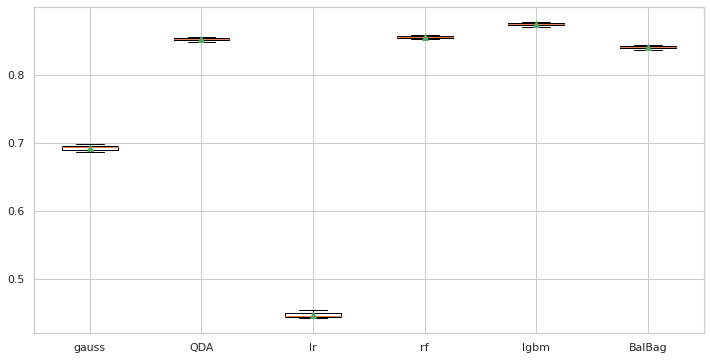

In [70]:
ax = plt.subplots(figsize=(12, 6))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [71]:
#Solution-1
mean_scores = []
for score in results:
    mean_scores.append(round(np.mean(score),3))
min_index = mean_scores.index(max(mean_scores))
model_name = names[min_index]

In [72]:
print(f'Best Score: {mean_scores[min_index]}')
print(f'Best Model: {model_name}')

Best Score: 0.874
Best Model: lgbm


In [73]:
%%time

models = get_models()
clf = models[model_name]
X = train_df[selected_features]
y = train_df[target]
clf.fit(X, y)

preds = clf.predict_proba(test_df[selected_features])
sub = pd.DataFrame()
sub['ID'] = test_df['ID']
sub['Is_Lead'] = preds[:, 1]

CPU times: user 1min 55s, sys: 16.7 ms, total: 1min 55s
Wall time: 58.8 s


In [74]:
sub.head()

,ID,Is_Lead
0,VBENBARO,0.040306
1,CCMEWNKY,0.866019
2,VK3KGA9M,0.057911
3,TT8RPZVC,0.022654
4,SHQZEYTZ,0.022673


In [75]:
sub.to_csv('Best_single_Model.csv', index=False)

In [76]:
#Final Solution
test_pred_all = None

for i in tqdm(range(NUM_SPLITS)):
    print('#'*50)
    print(f'{"*"*21} FOLD {i+1} {"*"*21}')
    
    train = train_df[train_df['kfold'] != i]
    valid = train_df[train_df['kfold'] == i]
    test = test_df
    
    clf = LGBMClassifier(metric='binary_logloss',
                         objective='binary',
                         reg_alpha=2.945525898790487,
                         max_depth=13,
                         num_leaves=34,
                         seed=42,
                         learning_rate=0.0037601596530868493,
                         n_estimators=20000)
    clf.fit(train[selected_features].values,train[target].values,
           eval_set=(valid[selected_features].values,valid[target].values),
                  eval_metric='binary_logloss',
           early_stopping_rounds=500,
           verbose=1000)
    
    pred = clf.predict_proba(valid[selected_features])[:, 1]
    roc = roc_auc_score(valid[target], pred)

    test_pred = clf.predict_proba(test[selected_features])[:, 1]
    if test_pred_all is None:
        test_pred_all = test_pred
    else:
        test_pred_all += test_pred
    
    print(f'ROC: {roc}')
    print('#'*50)
    
test_pred_all /= NUM_SPLITS
            

  0%|          | 0/5 [00:00<?, ?it/s]

##################################################
********************* FOLD 1 *********************
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's binary_logloss: 0.346543
[2000]	valid_0's binary_logloss: 0.344188
[3000]	valid_0's binary_logloss: 0.344071
Early stopping, best iteration is:
[3002]	valid_0's binary_logloss: 0.34407


 20%|██        | 1/5 [01:36<06:27, 97.00s/it]

ROC: 0.8738705888043106
##################################################
##################################################
********************* FOLD 2 *********************
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's binary_logloss: 0.345934
[2000]	valid_0's binary_logloss: 0.343672
Early stopping, best iteration is:
[2406]	valid_0's binary_logloss: 0.343628


 40%|████      | 2/5 [02:59<04:38, 92.68s/it]

ROC: 0.8730114731335283
##################################################
##################################################
********************* FOLD 3 *********************
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's binary_logloss: 0.344429
[2000]	valid_0's binary_logloss: 0.341974
[3000]	valid_0's binary_logloss: 0.341897
Early stopping, best iteration is:
[2519]	valid_0's binary_logloss: 0.341849


 60%|██████    | 3/5 [04:25<03:01, 90.61s/it]

ROC: 0.875191199695954
##################################################
##################################################
********************* FOLD 4 *********************
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's binary_logloss: 0.346121
[2000]	valid_0's binary_logloss: 0.343806
[3000]	valid_0's binary_logloss: 0.34374
Early stopping, best iteration is:
[3228]	valid_0's binary_logloss: 0.343722


 80%|████████  | 4/5 [06:08<01:34, 94.41s/it]

ROC: 0.8739839040580902
##################################################
##################################################
********************* FOLD 5 *********************
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's binary_logloss: 0.347607
[2000]	valid_0's binary_logloss: 0.345554
Early stopping, best iteration is:
[2289]	valid_0's binary_logloss: 0.345514


100%|██████████| 5/5 [07:29<00:00, 89.91s/it]

ROC: 0.8733627016890073
##################################################


In [77]:
sub_2 = pd.DataFrame()
sub_2['ID'] = test_df['ID']
sub_2['Is_Lead'] = test_pred_all

In [78]:
sub_2.head()

,ID,Is_Lead
0,VBENBARO,0.039612
1,CCMEWNKY,0.864450
2,VK3KGA9M,0.062147
3,TT8RPZVC,0.022508
4,SHQZEYTZ,0.022192
